In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from numpy import genfromtxt
import os
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("../../../")
from utils.utils import MyDataset, MyDatasetV2, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from networks.vae import VAE
from networks.vae_v2 import VAE_V2
from networks.ccvae import CCVAE
from networks.utils import EarlyStopper
import argparse
from algorithms.GA.utils import write_firewall_file, erase_firebreaks
from tqdm import tqdm


In [2]:
dataset = MyDatasetV2("../../../../data/complete_random/homo_2/")
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05], generator=torch.Generator().manual_seed(42))


In [ ]:
params = {}
params["latent_dims"] = 256
params["capacity"] = 128
params["use_gpu"] =  False
params["input_size"] = 20
params["epochs"] = 20
params["sigmoid"] = True
params["lr1"] = 1e-5
params["lr2"] = 1e-5
params["instance"] = "homo_2"
params["not_reduced"] = False
params["variational_beta"] = 0.1
params["distribution_std"] = 0.1
params["latent_portion"] = 0.5
params["alpha"] = 10000

In [4]:
model = CCVAE(params).to("cpu")
model.eval()

CCVAE(
  (conv1): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=6400, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=6400, out_features=256, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (encoder): Sequential(
    (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inpla

In [5]:
# Load weights
model.load_state_dict(torch.load(f'../../../weights/homo_2/CCVAE/sub20x20_latent=256_capacity=128_100_sigmoid=True_T1=100_T2=100_lr1=1e-05_lr2=1e-05_lr3=0.0001_normalize=False_weight_decay=0_not_reduced=False_variational_beta=0.1_distribution_std=0.1_alpha=100000.0.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [6]:
x, r = dataset[1]
recon, r_ = model(x.unsqueeze(0), r.unsqueeze(0))

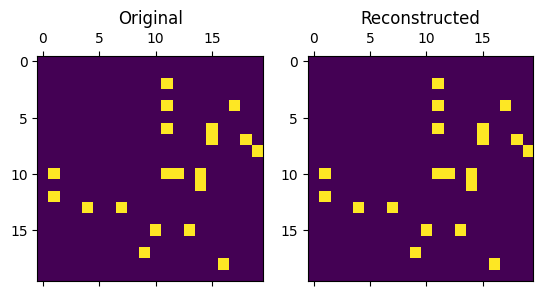

In [7]:
# Plotting the original binary matrix
plt.subplot(1, 2, 1)
plt.title('Original')
plt.matshow((x[0]), fignum=False)

# Plotting the reconstructed binary matrix
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.matshow((recon[0] >= 0.5)[0].int(), fignum=False)
plt.show()


In [9]:
burned_r = []
for x, r in tqdm(dataset):
    _, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
    burned_r.append(r_.item())

100%|██████████| 50000/50000 [02:28<00:00, 335.70it/s]


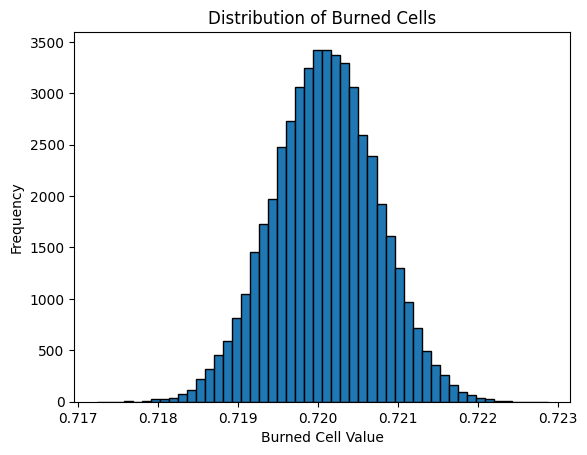

In [11]:
# plotting the distribution of burned_r
plt.hist(burned_r, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
model.training = True

In [8]:
x, r = dataset[6]
mu, log_sigma = model.encode(x.unsqueeze(0))

In [9]:
sample = model.latent_sample(mu, 10*log_sigma)

In [10]:
x, r = dataset[7]
mu_, log_sigma_ = model.encode(x.unsqueeze(0))

In [11]:
alpha = 0.5
interp = alpha * mu + (1 - alpha) * mu_

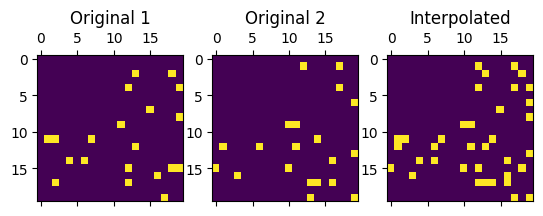

In [12]:
# Plot the original image and the sampled image and interp
plt.subplot(1, 3, 1)
plt.title('Original 1')
plt.matshow((x[0] > 0).int(), fignum=False)

plt.subplot(1, 3, 2)
plt.title('Original 2')
plt.matshow(model.decode(sample)[0][0] >= 0.5, fignum=False)

plt.subplot(1, 3, 3)
plt.title('Interpolated')
plt.matshow(model.decode(interp)[0][0] >= 0.5, fignum=False)

plt.show()


In [13]:
def calc_fitness(model, embedding, n_sims = 50):
        """
        Calculates the average number of burned cells of embedding's associated
        solution.
        """
        print(embedding.shape)
        solution = model.decode(embedding[0])
        _, indices = torch.topk(solution.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        assert(matrix.sum().item() == 20)
        write_firewall_file(matrix * -1.)
        n_weathers = len([i for i in os.listdir("../../../../data/complete_random/homo_2/Sub20x20/Weathers/") if i.endswith('.csv')])-2
        exec_str = f"../../../algorithms/eval/C2F-W/Cell2FireC/Cell2Fire --input-instance-folder ../../../../data/complete_random/homo_2/Sub20x20/ --output-folder ../../../algorithms/eval/results/ --sim-years 1 --nsims {n_sims}--Fire-Period-Length 1.0 --output-messages --ROS-CV 0.0 --seed 123 --weather random --ignitions --IgnitionRad 4 --sim C --final-grid --nweathers {n_weathers} --FirebreakCells ../../../algorithms/eval/harvested/HarvestedCells.csv"
        os.system(exec_str + " >/dev/null 2>&1")
        reward = 0
        base_directory = f"../../../algorithms/eval/results/Grids/Grids"
        for j in range(1, n_sims+1):
            dir = f"{base_directory}{str(j)}/"
            print(dir)
            files = os.listdir(dir)
            my_data = genfromtxt(dir+files[-1], delimiter=',')
            # Burned cells are counted and turned into negative rewards
            for cell in my_data.flatten():
                if cell == 1:
                    reward-= 1
        erase_firebreaks()
        return 1 + ((reward/n_sims) / 400)

In [14]:
calc_fitness(model, interp.unsqueeze(0), n_sims=10)

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/


0.7475